<a href="https://colab.research.google.com/github/Harumaru58/ASD_Autora_notebooks/blob/main/bayesModelTutorial_wChangepoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

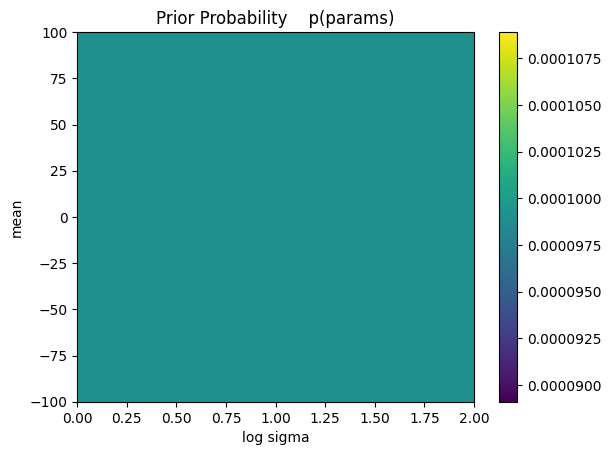

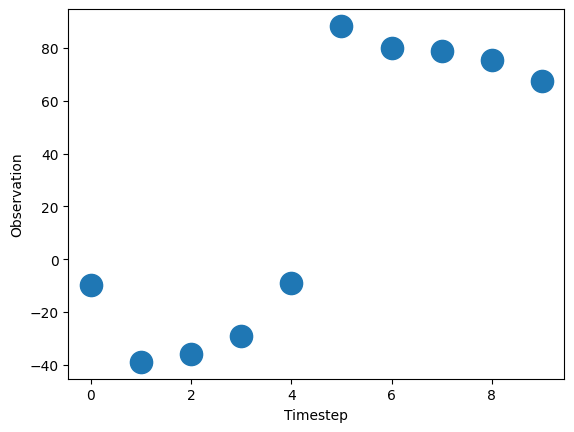

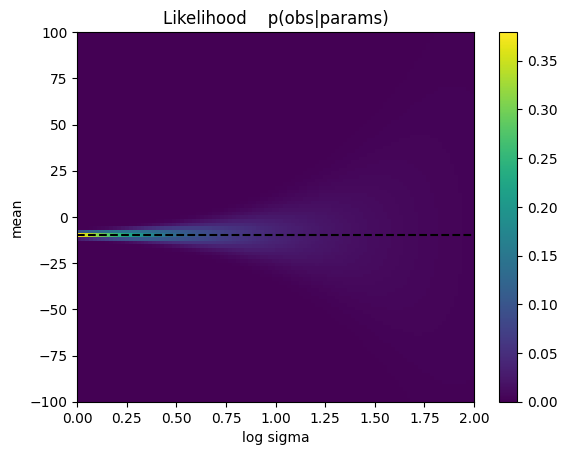

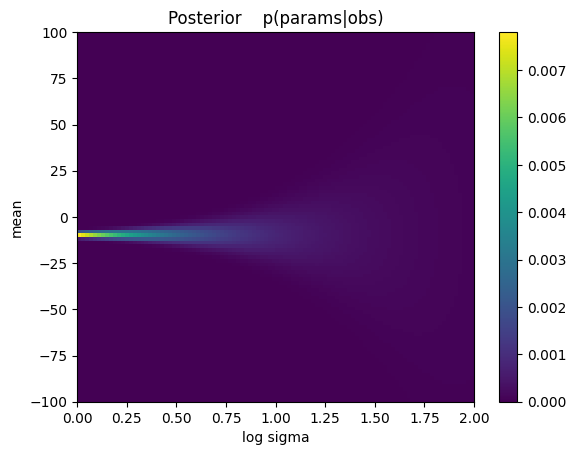

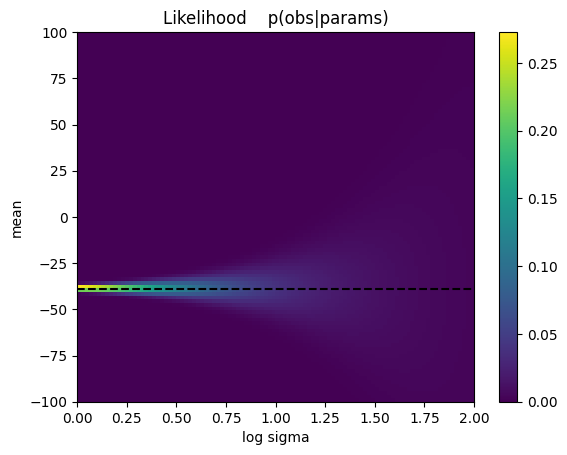

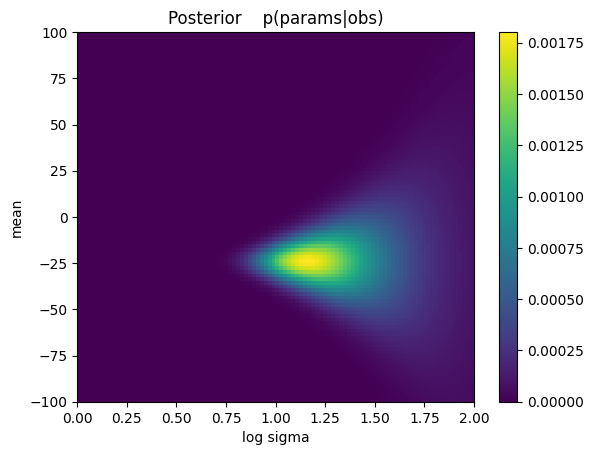

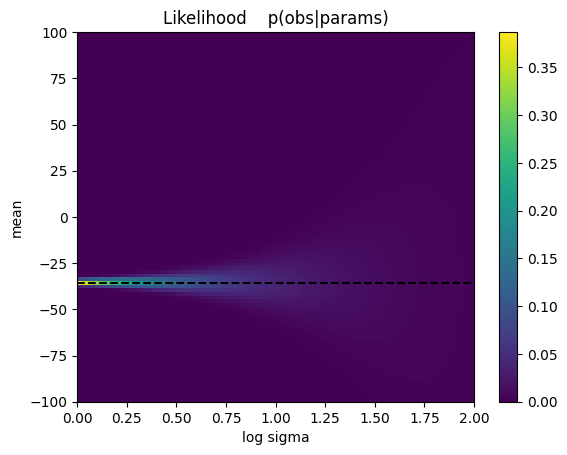

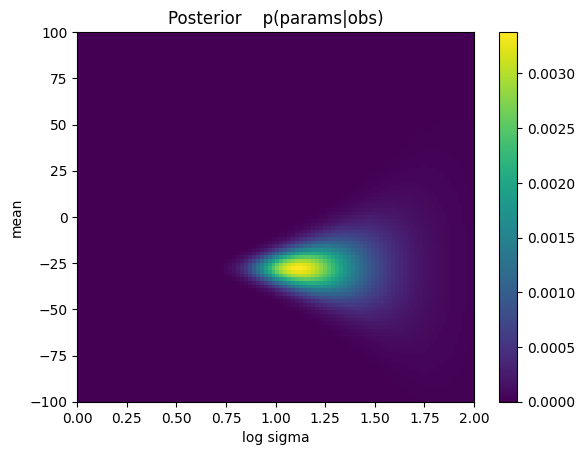

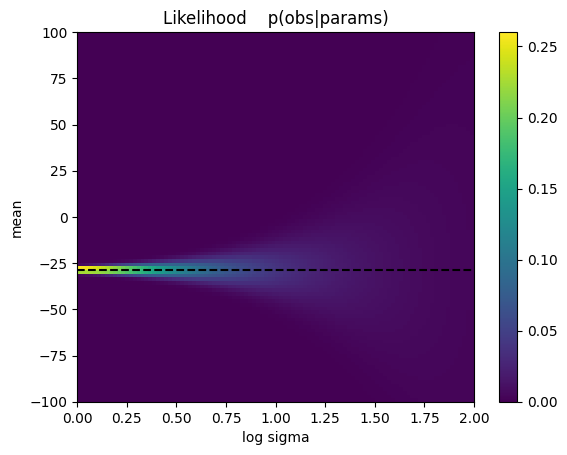

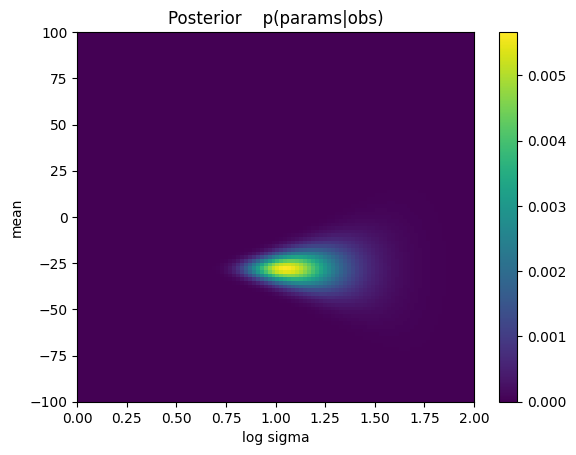

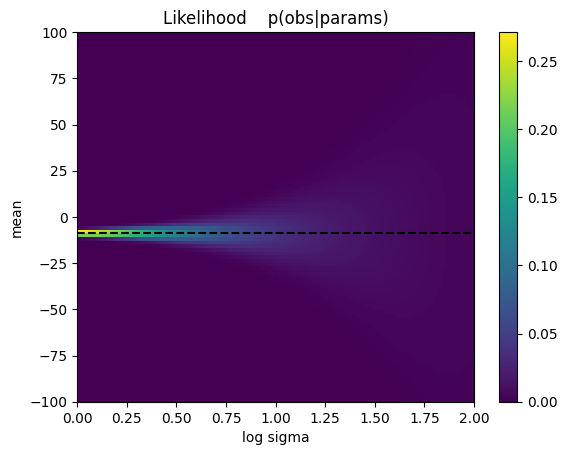

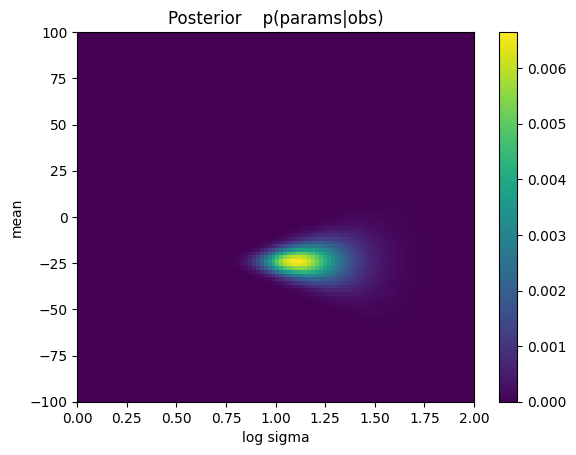

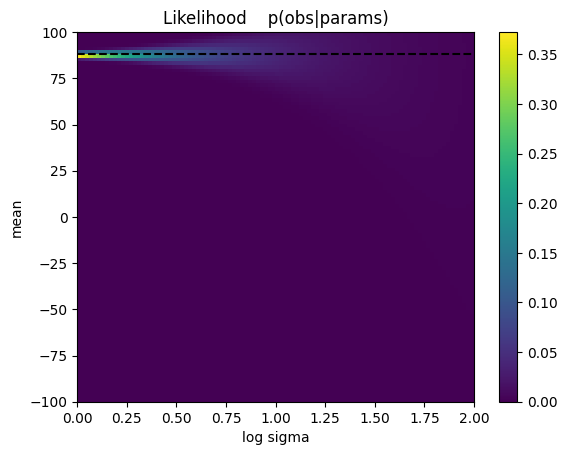

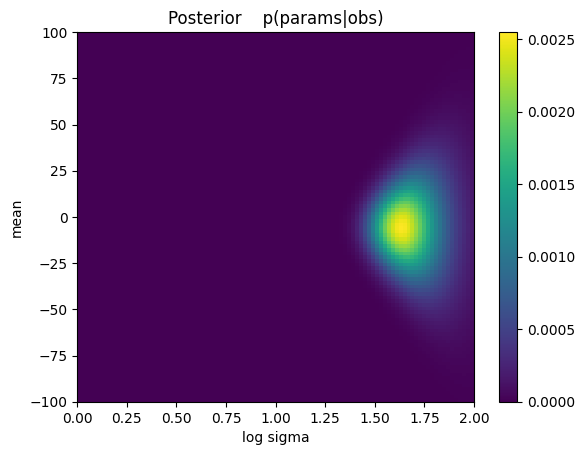

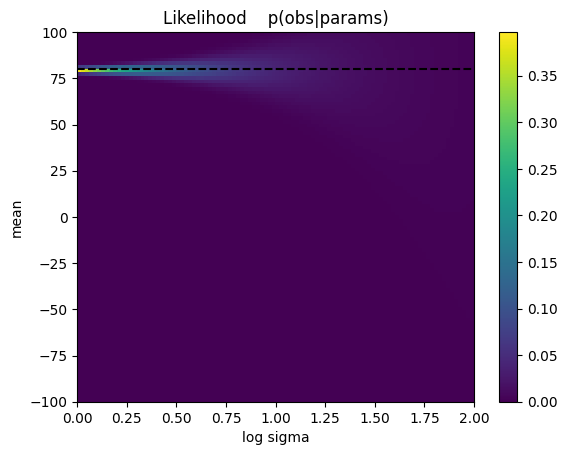

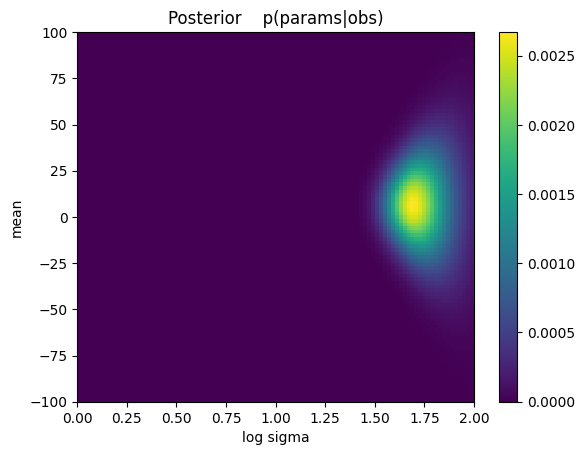

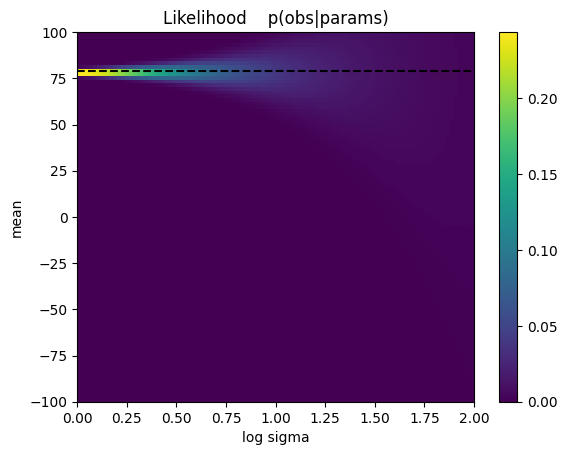

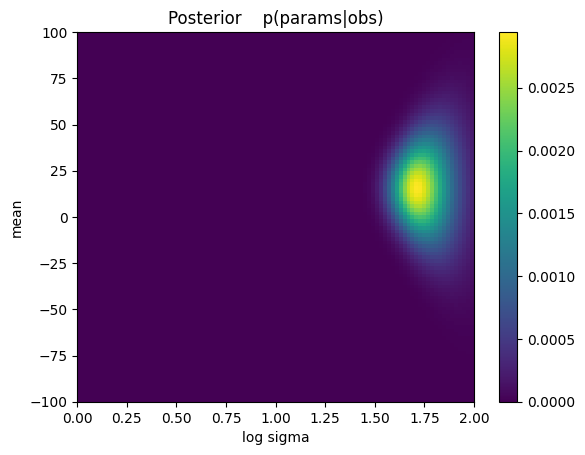

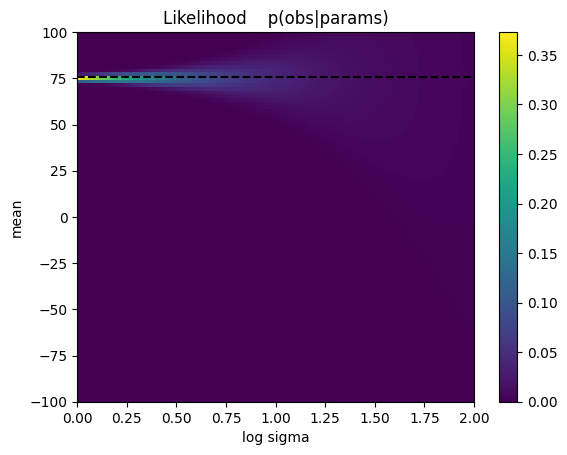

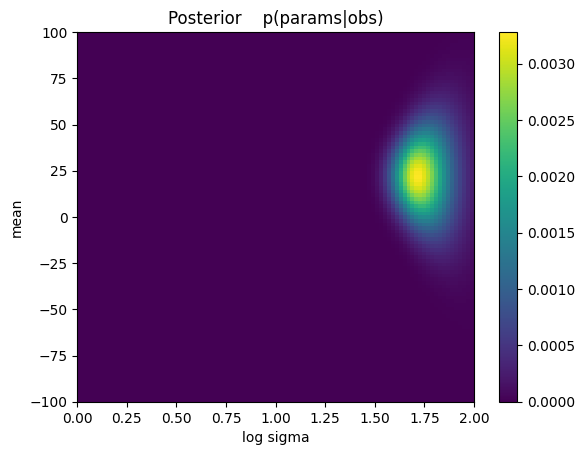

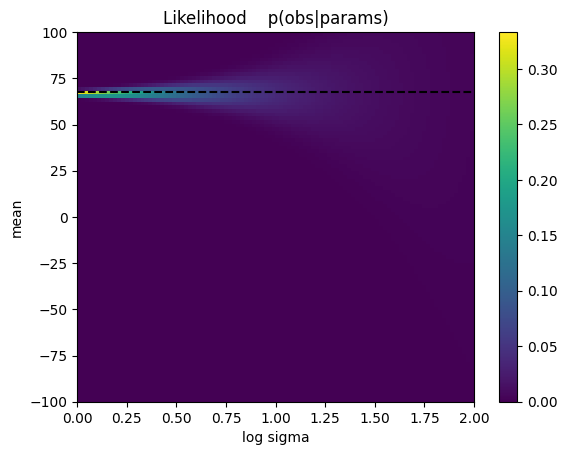

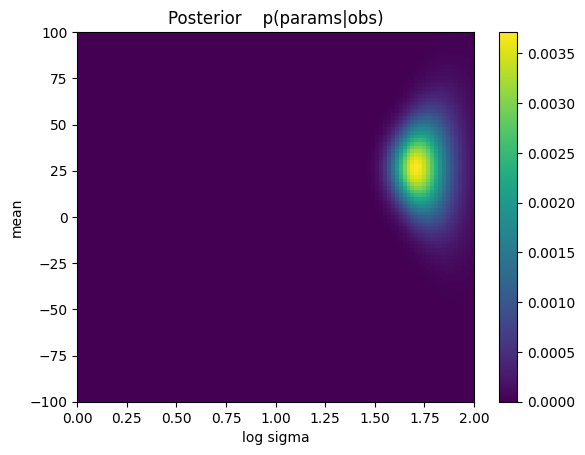

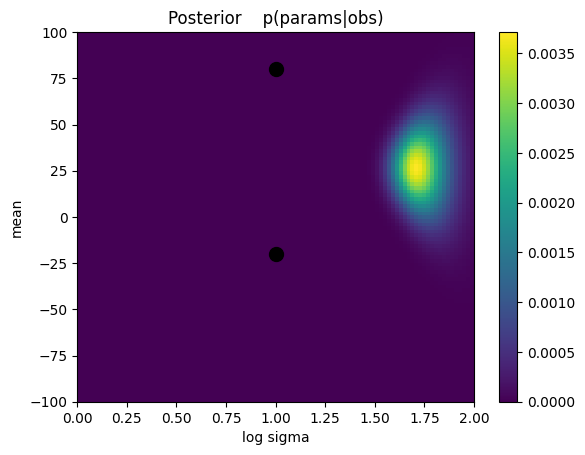

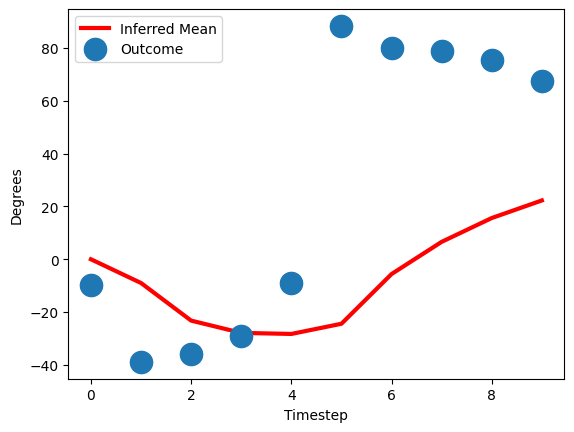

In [ ]:
# %%
# Example of Bayesian inference in presence of changepoints:

# Goal: Demonstrate how Bayesian inference can be used to infer the mean
# and standard deviation of the distribution that is generating a bunch of
# data -- when there are occasional changepoints.

# Additional resources: First two chapters of David MacKay book
# (MacKay.pdf) as well as MRN slides for modeling workshop
# (ModelingWorkshop_8-17-21).

# How to use this script:
# This script is meant to be run AFTER having played around with the
# "BayesModelTutorial.m" script.
# It is almost the same model, except that it adds in a changepoint
# transition structure -- such that the mean/std on each time step is
# assumed to occasionally be resampled.

# In order to understand Bayesian inference, it is probably best to look
# through the script line by line (it isn't long!) then run everything up
# to the for loop (~line 80). Instead of running the for loop all at
# once... I recommend running the code inside the loop a few times and
# looking at the plot of likelihoods and posteriors each time... how are they
# updated in response to new observations? Then, once you've gone through a
# few trials manually, you can run the whole script and see what happens...
# once you've done that probably also worth trying to change the
# "environment" to be a different mean/standard deviation and see if/how
# the model learns differently.
# Start with the hazard rate set to zero - this means that the Bayesian
# model never expects any changepoints.
# Then turn up the hazard rate and see how its updating changes...

# MRN 8/15/18
# Made for Computational Modeling Workshop at Brown University
# Organized by Andra Geana

# %%
# Steps:

# 1) create an environment
# 2) create observations.
# 3) compute likelihood of that observation under different hypotheses
# 4) update posterior probability according to new likelihood.
# 5) look at results.

# %%
# ENVIRONMENT: UNOBSERVABLE!!!!

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Our "world" is pretty simple -- there is a normal distribution with a mean
# and variance that gives rise to observations.

trueSig = 10

# Now we will have the distribution change after nSteps1:
nSteps1 = 5
nSteps2 = 5

# And we will specify the first and second mean:
trueMean1 = -20
trueMean2 = 80  # in this simulation we will have the mean of the distribution change to a new value...

hazard = 0  # how frequently does the model expect "changepoints"?

# %%
# Create outcomes and do inference

# total number of steps is the number of steps where we see observations
# from the first distribution plus the number of steps where we see
# observations from the second distribution.
nSteps = nSteps1 + nSteps2

# Build distribution over possible parameter values (eg. model of environment)
possibleMeans = np.arange(-100, 102, 2)
possibleSigmas = np.logspace(0, 2, 100)

# Create a flat "prior" distribution assumed to resample distributions...
flatDist = np.ones((len(possibleMeans), len(possibleSigmas))) / (len(possibleMeans) * len(possibleSigmas))

# This is our "Prior" over possible parameter values in the environment:
paramProb = flatDist

# Look at our prior distribution:
plt.imshow(paramProb, aspect='auto', extent=[0, 2, -100, 100], origin='lower')
plt.colorbar()
plt.title('Prior Probability    p(params)')
plt.ylabel('mean')
plt.xlabel('log sigma')
plt.show()

# %%
# Now, make an observation, and update probability distribution over parameter values:

# Here is a timeseries of observations that we will encounter:
allObservations = np.concatenate([np.random.normal(trueMean1, trueSig, nSteps1),
                                  np.random.normal(trueMean2, trueSig, nSteps2)])

# make a plot of observations over time:
plt.plot(allObservations, 'o', markersize=16)
plt.ylabel('Observation')
plt.xlabel('Timestep')
plt.show()

obsLike = np.empty_like(paramProb)
expMean = np.empty(nSteps)

for i in range(nSteps):
    # Store model expectation about mean on each trial:
    expMean[i] = np.dot(possibleMeans, np.sum(paramProb, axis=1))

    # Make observation:
    observation = allObservations[i]

    # Compute likelihood of observation
    # Compute likelihood from each possible parameter value under
    # assumption that the world has NOT changed:
    for ss in range(len(possibleSigmas)):
        for mm in range(len(possibleMeans)):
            obsLike[mm, ss] = norm.pdf(observation, possibleMeans[mm], possibleSigmas[ss])

    # Look at likelihood (eg. probability of data given model & parameters)
    plt.figure(1)
    plt.imshow(obsLike, aspect='auto', extent=[0, 2, -100, 100], origin='lower')
    plt.colorbar()
    plt.title('Likelihood    p(obs|params)')
    plt.ylabel('mean')
    plt.xlabel('log sigma')
    plt.plot([0, 2], [observation, observation], '--k')
    plt.show()

    # Solve for the likelihood of the data in the presence of changepoints:
    paramProbNew = (hazard) * flatDist + (1 - hazard) * paramProb

    # Update probability distribution over parameter values:
    paramProb = paramProbNew * obsLike
    # Normalize for outcome probability
    paramProb = paramProb / np.sum(paramProb)

    plt.figure(1)
    plt.imshow(paramProb, aspect='auto', extent=[0, 2, -100, 100], origin='lower')
    plt.colorbar()
    plt.title('Posterior    p(params|obs)')
    plt.ylabel('mean')
    plt.xlabel('log sigma')
    plt.show()

# Plot posterior distribution
plt.figure(1)
plt.imshow(paramProb, aspect='auto', extent=[0, 2, -100, 100], origin='lower')
plt.colorbar()
plt.title('Posterior    p(params|obs)')
plt.ylabel('mean')
plt.xlabel('log sigma')
plt.plot([np.log10(trueSig), np.log10(trueSig)], [trueMean1, trueMean2], 'ok', markersize=10)
plt.show()

# Plot inferred mean over time
plt.figure(2)
plt.plot(expMean, '-r', linewidth=3)
plt.plot(allObservations, 'o', markersize=16)
plt.ylabel('Degrees')
plt.xlabel('Timestep')
plt.legend(['Inferred Mean', 'Outcome'])
plt.show()
